In [27]:
import pandas as pd
import numpy as np

etf_df = pd.read_csv('../data/etf_df.csv', parse_dates=['timestamp'])
crypto_df = pd.read_csv('../data/crypto_df.csv', parse_dates=['timestamp'])


def restructure(df):
    df = df.pivot(index='timestamp', columns='symbol', values=[col for col in df.columns if col not in ['symbol', 'timestamp']]).reset_index()
    df['date'] = df['timestamp'].dt.date    
    return df

def compute_log_returns(df, df_col):
    
    df[[f'LR_{sym}' for sym in df[df_col].columns]] = df[df_col][[sym for sym in df[df_col].columns]].map(np.log)

    for sym in df[df_col].columns:
        df[f'LR_{sym}'] = df.groupby('date')[f'LR_{sym}'].diff()

    return df
    
def log_return_impute(df, tkn='BTC/USD'):
    LR_syms = [f'LR_{sym}' for sym in df['close'].columns if tkn not in sym]
    # LR = df[LR_syms].droplevel(1, axis=1)
    iLR = df[f'LR_{tkn}']
    for LR_sym in LR_syms:
        df[LR_sym] = df[LR_sym].fillna(iLR)

    return df

def compute_volatility(df, sym='BTC/USD'):    
    df[f'sigmasq_{sym}'] = df[f'LR_{sym}'].map(np.square)
    return df
    
    
def get_features(df, tkn='BTC/USD'):
    df['dt'] = df.groupby('date_x')['timestamp'].diff().dt.seconds / 60

    # ts = df['timestamp']
    tc = df['trade_count'].add_prefix('trade_count_')
    vol = df['volume'].add_prefix('volume_')
    lr = (df[[col for col,_ in df.columns if 'LR_' in col]].droplevel(1, axis=1).T / df['dt']).T
    sg = df[f'sigmasq_{tkn}']

    return pd.concat([df['dt'], vol, tc, lr, sg], axis=1).fillna(0)

df = etf_df\
    .pipe(restructure)\
    .pipe(compute_log_returns, df_col='close')\
    .merge(
        crypto_df\
            .pipe(restructure)
            .pipe(compute_log_returns, df_col='close'), on='timestamp'
        )\
    .pipe(log_return_impute)\
    .pipe(compute_volatility)\
    .pipe(get_features)


/var/folders/c8/c3xvsb_56wq1czrwq0kr796c0000gn/T/ipykernel_98476/3843930051.py:50: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  .merge(


In [28]:
df.drop('LR_BITX', axis=1, inplace=True)

## Random Forest

In [29]:
SYM = 'LR_IBIT'

df = df.iloc[:df.shape[0] // 5]
tdf = df.iloc[df.shape[0] // 5:]

y = df[SYM].shift(-1).fillna(0)
yt = tdf[SYM].shift(-1).fillna(0)

# X = df[[col for col in df.columns if 'IBIT' not in col]]
X = df.drop(['dt', 'trade_count_BTC/USD'], axis=1)
Xt = tdf.drop(['dt', 'trade_count_BTC/USD'], axis=1)

# for col in X.columns:
#     if 'LR' in col:
#         X[f'Sign_{col}'] = np.where(X[f'{col}'] > 0, 1, -1)

# for col in Xt.columns:
#     if 'LR' in col:
#         Xt[f'Sign_{col}'] = np.where(Xt[f'{col}'] > 0, 1, -1)

y.head(), X.head()

(0   -0.000105
 1    0.000331
 2    0.000330
 3    0.000509
 4    0.000238
 Name: LR_IBIT, dtype: float64,
    volume_BITO  volume_BITX  volume_IBIT  volume_BTC/USD  trade_count_BITO  \
 0       5413.0        625.0          0.0             0.0              66.0   
 1       8397.0        477.0          0.0             0.0              25.0   
 2       1111.0       1303.0          0.0             0.0              11.0   
 3       1776.0        747.0          0.0             0.0              11.0   
 4       2007.0        246.0          0.0             0.0              10.0   
 
    trade_count_BITX  trade_count_IBIT   LR_BITO   LR_IBIT  LR_BTC/USD  \
 0              11.0               0.0  0.000000  0.000000    0.000000   
 1               9.0               0.0  0.002210 -0.000105   -0.000105   
 2              19.0               0.0  0.000000  0.000331    0.000331   
 3              10.0               0.0  0.000000  0.000330    0.000330   
 4               8.0               0.0  0.00132

In [30]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the random forest classifier model
modelR = RandomForestRegressor(random_state=42)
modelR.fit(X_train, y_train)

modelC = RandomForestClassifier(random_state=42)
modelC.fit(X_train, np.where(y_train > 0, 1, -1))

# Make predictions
y_pred = modelR.predict(X_test)
y_predC = modelC.predict(X_test)
y_prob = modelC.predict_proba(X_test)

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
# Output the classification report and confusion matrix
print(classification_report(np.where(y_test > 0, 1, -1), y_predC))
print(confusion_matrix(np.where(y_test > 0, 1, -1), y_predC))

              precision    recall  f1-score   support

          -1       0.55      0.64      0.59      3816
           1       0.50      0.41      0.45      3358

    accuracy                           0.53      7174
   macro avg       0.53      0.52      0.52      7174
weighted avg       0.53      0.53      0.53      7174

[[2438 1378]
 [1978 1380]]


In [33]:
y_pred = modelR.predict(Xt)
y_prob = modelC.predict_proba(Xt)
y_test = yt

M = pd.concat([pd.Series(y_pred).rename('pred').reset_index(),pd.Series(y_prob[:,0]).rename('prob').reset_index(),pd.Series(y_test).rename('true').reset_index()], axis=1)

0.0003790582741374247


<Axes: ylabel='Frequency'>

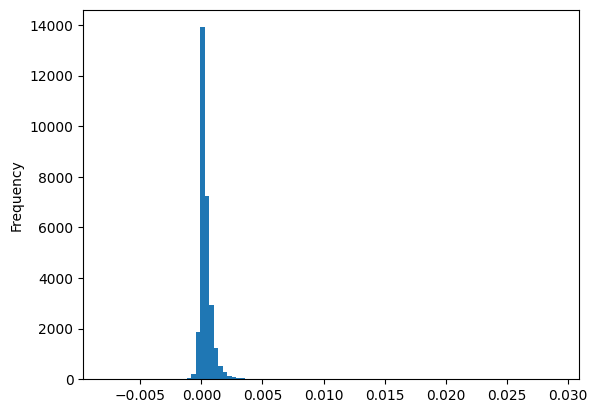

In [34]:
M['r'] = M['true'].map(np.sign) * M['pred']
print(M['r'].mean())
M['r'].plot(kind='hist', bins=100)

0.0005360228633294475


<Axes: ylabel='Frequency'>

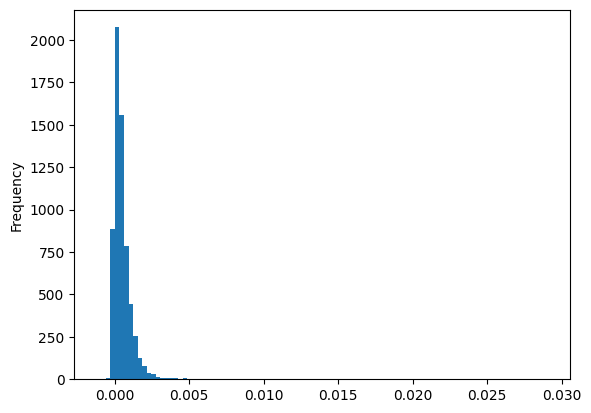

In [35]:
a = 0.15
M.loc[(M['prob'] < a) | (M['prob'] > (1-a)), 'r'].mean() / M.loc[(M['prob'] < 0.4) | (M['prob'] > 0.6), 'r'].std()
print(M.loc[(M['prob'] < a) | (M['prob'] > (1-a)), 'r'].mean())
M.loc[(M['prob'] < a) | (M['prob'] > (1-a)), 'r'].plot(kind='hist', bins=100)

In [46]:
a = 0.1

print(M.loc[(M['prob'] < a), 'r'].mean())
M.loc[(M['prob'] < a), 'r'].cumsum()

0.0007286273678291832


23       0.000219
56       0.001222
125      0.001486
272      0.001707
409      0.001770
           ...   
28451    0.230933
28467    0.231003
28477    0.231503
28578    0.233429
28674    0.235347
Name: r, Length: 323, dtype: float64

<Axes: >

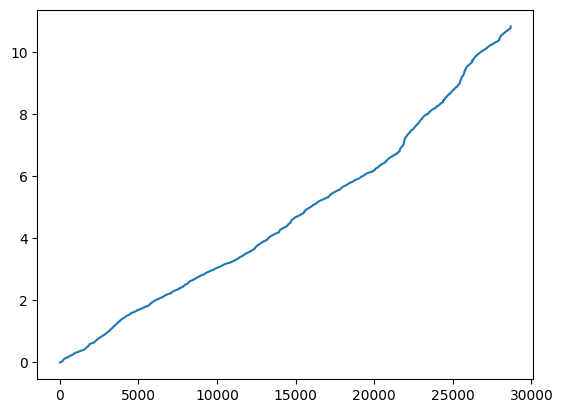

In [24]:
a = 0.4
M.loc[(M['prob'] < a) | (M['prob'] > (1-a)), 'r'].cumsum().plot()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'volume_BITO'),
  Text(1, 0, 'volume_BITX'),
  Text(2, 0, 'volume_IBIT'),
  Text(3, 0, 'volume_BTC/USD'),
  Text(4, 0, 'trade_count_BITO'),
  Text(5, 0, 'trade_count_BITX'),
  Text(6, 0, 'trade_count_IBIT'),
  Text(7, 0, 'LR_BITO'),
  Text(8, 0, 'LR_BITX'),
  Text(9, 0, 'LR_IBIT'),
  Text(10, 0, 'LR_BTC/USD'),
  Text(11, 0, 'sigmasq_BTC/USD')])

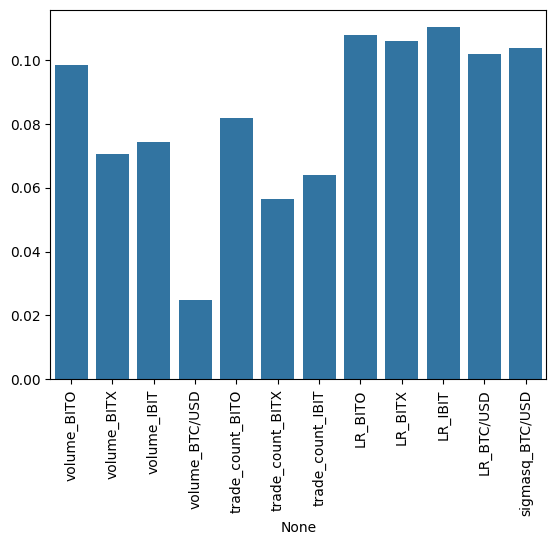

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=Xt.columns, y=modelC.feature_importances_)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'volume_BITO'),
  Text(1, 0, 'volume_BITX'),
  Text(2, 0, 'volume_IBIT'),
  Text(3, 0, 'volume_BTC/USD'),
  Text(4, 0, 'trade_count_BITO'),
  Text(5, 0, 'trade_count_BITX'),
  Text(6, 0, 'trade_count_IBIT'),
  Text(7, 0, 'LR_BITO'),
  Text(8, 0, 'LR_BITX'),
  Text(9, 0, 'LR_IBIT'),
  Text(10, 0, 'LR_BTC/USD'),
  Text(11, 0, 'sigmasq_BTC/USD')])

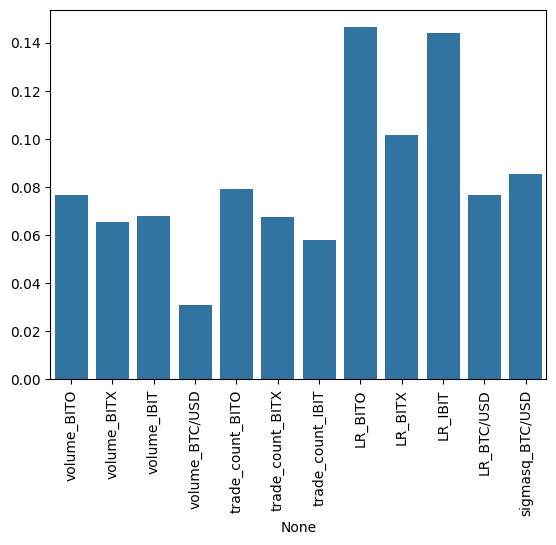

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=Xt.columns, y=modelR.feature_importances_)
plt.xticks(rotation=90)

<Axes: >

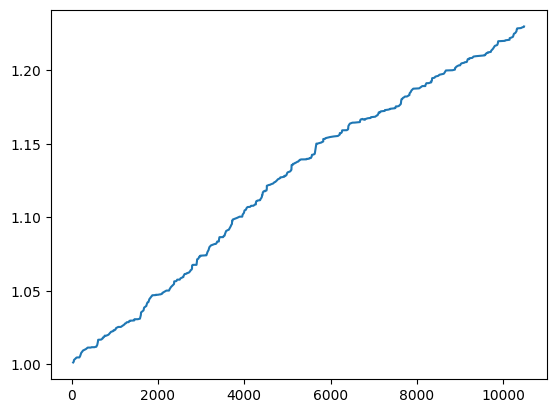

In [12]:
a = 0.1

# M.loc[(M['prob'] < a) | (M['prob'] > (1-a)), 'r'].plot(kind='hist', bins=100)
M.loc[(M['prob'] < a) | (M['prob'] > (1-a)), 'r'].cumsum().map(np.exp).iloc[:450].plot()



<Axes: >

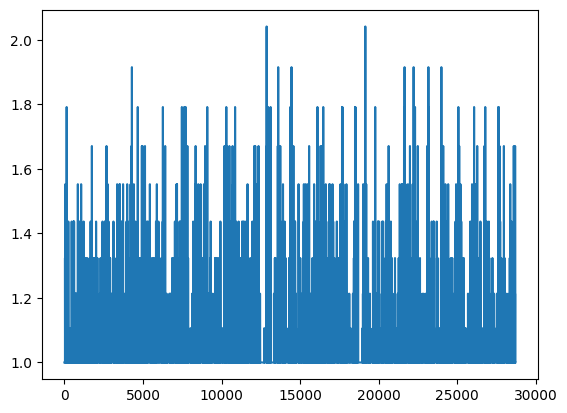

In [13]:
M['vol'] = 1 + 13*((M['prob'] - a) * (M['prob'] - (1-a))).map(lambda x: x if x > 0 else 0)
M['vol'].plot()

## Deviance

In [2]:
TKN = 'LR_BTC/USD'
SYM = 'LR_IBIT'

LR_ETF = [sym for sym in df.columns if 'LR_' in sym and TKN not in sym]
LR_ETF_DEV = [f'{sym}_dev' for sym in LR_ETF]


df[LR_ETF_DEV] = df[LR_ETF].T.sub(df[TKN]).T
df = df.drop([sym for sym in LR_ETF if sym != SYM], axis=1)
df = df.drop(['LR_BTC/USD', 'trade_count_BTC/USD'], axis=1)
df

,dt,trade_count_BITO,trade_count_BITX,trade_count_IBIT,LR_IBIT,sigmasq_BTC/USD,LR_BITO_dev,LR_BITX_dev,LR_IBIT_dev
0,0.0,66.0,11.0,0.0,0.000000,7.765532e-07,0.000000,0.000000,0.000000
1,1.0,25.0,9.0,0.0,-0.000105,1.110681e-08,0.002315,0.029470,0.000000
2,1.0,11.0,19.0,0.0,0.000331,1.092503e-07,-0.000331,0.003691,0.000000
3,1.0,11.0,10.0,0.0,0.000330,1.090341e-07,-0.000330,-0.000695,0.000000
4,1.0,10.0,8.0,0.0,0.000509,2.591313e-07,0.000815,0.002770,0.000000
...,...,...,...,...,...,...,...,...,...
179346,2.0,0.0,0.0,6.0,0.000044,7.730863e-09,0.000000,0.000000,0.000000
179347,1.0,1.0,7.0,16.0,0.000760,7.843813e-08,0.000000,0.000000,0.000480
179348,2.0,0.0,0.0,9.0,0.000195,1.524740e-07,0.000000,0.000000,0.000000
179349,1.0,0.0,5.0,10.0,-0.000760,1.721866e-08,0.000000,0.000000,-0.000628


In [230]:
df = df.iloc[:df.shape[0] // 5]
tdf = df.iloc[df.shape[0] // 5:]

y = df[SYM].shift(-1).fillna(0)
yt = tdf[SYM].shift(-1).fillna(0)

# X = df[[col for col in df.columns if 'IBIT' not in col]]
X = df.drop(['dt', 'LR_IBIT'], axis=1)
Xt = tdf.drop(['dt', 'LR_IBIT'], axis=1)

In [231]:
X

,trade_count_BITO,trade_count_BITX,trade_count_IBIT,sigmasq_BTC/USD,LR_BITO_dev,LR_BITX_dev,LR_IBIT_dev
0,66.0,11.0,0.0,7.765532e-07,0.000000,0.000000,0.000000
1,25.0,9.0,0.0,1.110681e-08,0.002315,0.029470,0.000000
2,11.0,19.0,0.0,1.092503e-07,-0.000331,0.003691,0.000000
3,11.0,10.0,0.0,1.090341e-07,-0.000330,-0.000695,0.000000
4,10.0,8.0,0.0,2.591313e-07,0.000815,0.002770,0.000000
...,...,...,...,...,...,...,...
35865,21.0,14.0,64.0,6.101537e-07,0.000175,0.000000,0.000049
35866,16.0,16.0,19.0,1.209173e-06,-0.000191,-0.001970,-0.000856
35867,40.0,13.0,109.0,5.876461e-07,-0.000445,-0.000627,-0.000454
35868,43.0,19.0,24.0,7.293016e-07,0.000854,-0.000018,0.001587


In [232]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the random forest classifier model
modelR = RandomForestRegressor(random_state=42)
modelR.fit(X_train, y_train)

modelC = RandomForestClassifier(random_state=42)
modelC.fit(X_train, np.where(y_train > 0, 1, -1))

# Make predictions
y_pred = modelR.predict(X_test)
y_predC = modelC.predict(X_test)
y_prob = modelC.predict_proba(X_test)

In [233]:
from sklearn.metrics import classification_report, confusion_matrix
# Output the classification report and confusion matrix
print(classification_report(np.where(y_test > 0, 1, -1), y_predC))
print(confusion_matrix(np.where(y_test > 0, 1, -1), y_predC))

              precision    recall  f1-score   support

          -1       0.55      0.62      0.58      3816
           1       0.50      0.42      0.46      3358

    accuracy                           0.53      7174
   macro avg       0.52      0.52      0.52      7174
weighted avg       0.52      0.53      0.52      7174

[[2367 1449]
 [1933 1425]]


In [234]:
y_pred = modelR.predict(Xt)
y_prob = modelC.predict_proba(Xt)
y_test = yt

M = pd.concat([pd.Series(y_pred).rename('pred').reset_index(),pd.Series(y_prob[:,0]).rename('prob').reset_index(),pd.Series(y_test).rename('true').reset_index()], axis=1)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'trade_count_BITO'),
  Text(1, 0, 'trade_count_BITX'),
  Text(2, 0, 'trade_count_IBIT'),
  Text(3, 0, 'sigmasq_BTC/USD'),
  Text(4, 0, 'LR_BITO_dev'),
  Text(5, 0, 'LR_BITX_dev'),
  Text(6, 0, 'LR_IBIT_dev')])

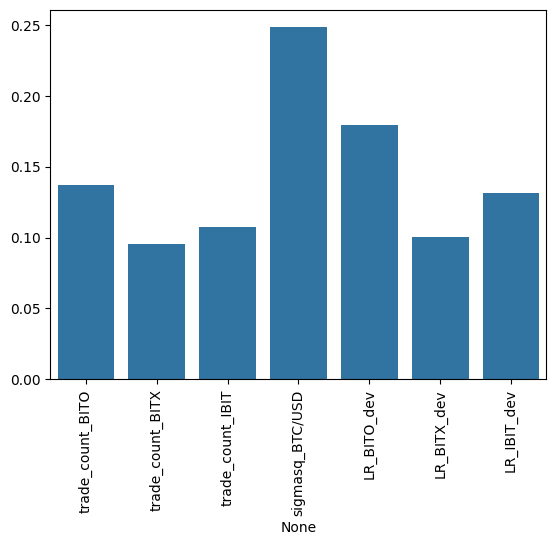

In [235]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=Xt.columns, y=modelC.feature_importances_)
plt.xticks(rotation=90)

0.0003769170226594818


<Axes: ylabel='Frequency'>

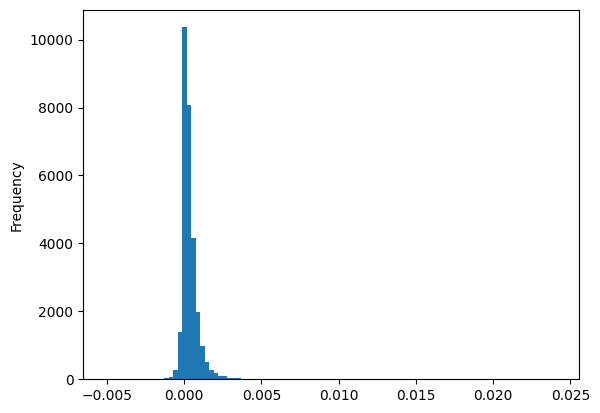

In [236]:
M['r'] = M['true'].map(np.sign) * M['pred']
print(M['r'].mean())
M['r'].plot(kind='hist', bins=100)

0.0005305669723735514


<Axes: ylabel='Frequency'>

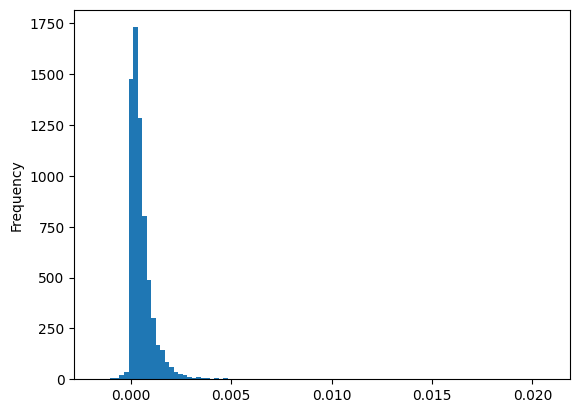

In [237]:
a = 0.15
M.loc[(M['prob'] < a) | (M['prob'] > (1-a)), 'r'].mean() / M.loc[(M['prob'] < 0.4) | (M['prob'] > 0.6), 'r'].std()
print(M.loc[(M['prob'] < a) | (M['prob'] > (1-a)), 'r'].mean())
M.loc[(M['prob'] < a) | (M['prob'] > (1-a)), 'r'].plot(kind='hist', bins=100)

<Axes: >

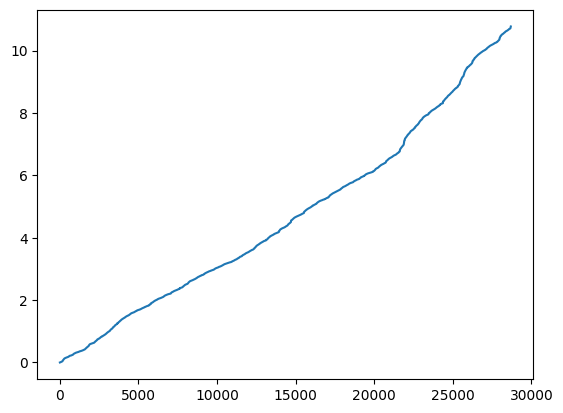

In [238]:
a = 0.4
M.loc[(M['prob'] < a) | (M['prob'] > (1-a)), 'r'].cumsum().plot()